In [1]:
from micromet.spectral import SpectralAnalysis
from micromet.specplot import SpectralPlots

In [5]:
import numpy as np

In [7]:
import pandas as pd
df = pd.read_csv("../data/Example_High_Freq.csv")
#df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])
#df.set_index('TIMESTAMP', inplace=True)
df.astype(np.float32)

,Ux,Uy,Uz,CO2,H2O,T_SONIC
0,-1.451676,-0.117134,-0.266250,607.351318,7.521346,23.828890
1,-1.621312,-0.368383,-0.034449,607.605225,7.524221,23.782841
2,-1.982984,-0.520821,-0.106899,607.655579,7.503823,23.928530
3,-1.881826,-0.613461,-0.241413,607.588379,7.480763,23.997860
4,-1.899965,-0.680706,-0.084453,607.349915,7.478708,23.948879
...,...,...,...,...,...,...
17995,-1.955387,-0.819904,-0.184979,596.228210,7.563963,26.273861
17996,-1.746440,-0.945301,0.029276,595.431091,7.635378,26.293240
17997,-1.803562,-1.008897,-0.020951,594.927124,7.665899,26.339600
17998,-1.887252,-1.135802,-0.188595,594.666870,7.697655,26.312160


Loaded data with sampling frequency: 10 Hz

1. Computing basic spectra and cospectra...

2. Performing advanced spectral analysis...


C:\Users\paulinkenbrandt\Documents\GitHub\MicroMet\micromet\spectral.py:405: RuntimeWarning: invalid value encountered in power
  return (f / f_peak) / (1 + (f / f_peak) ** (broadness * slope))


Vertical wind spectral parameters:
Peak frequency: 0.000 Hz
Spectral slope: -1.287
R² of fit: -0.001
Estimated noise floor: 1.071e+02

3. Performing quality control checks...
QC results: {'Resolution': np.False_, 'Slope': np.False_, 'Noise': np.False_}

4. Computing transfer functions and corrections...
Original flux: -1.735
Corrected flux: -1.818

5. Creating plots...


C:\Users\paulinkenbrandt\Documents\GitHub\MicroMet\micromet\specplot.py:65: RuntimeWarning: divide by zero encountered in power
  ref_line = f_range**(-5/3) * np.max(spectrum) * 10
C:\Users\paulinkenbrandt\Documents\GitHub\MicroMet\micromet\specplot.py:115: RuntimeWarning: divide by zero encountered in power
  ref_line = f_range**(-7/3) * np.max(cospec) * 10


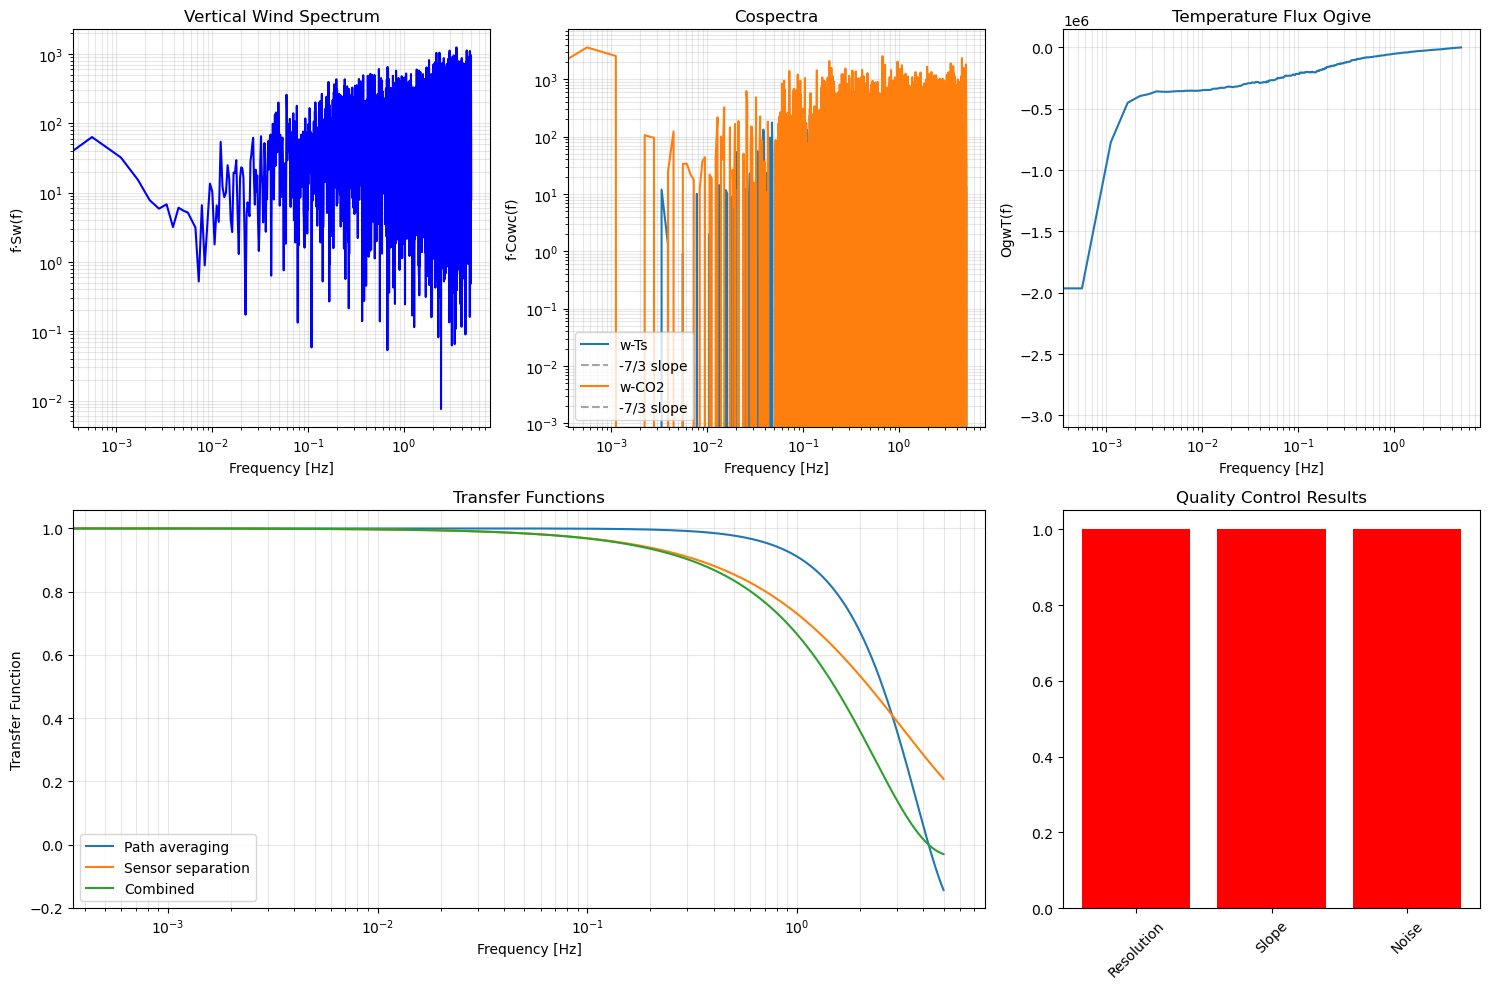


Analysis complete!


In [8]:
"""
Example demonstrating usage of the eddy covariance spectral analysis module
"""

import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple

# Import our modules (assuming they're saved as spectral_analysis.py and spectral_plots.py)
from micromet.spectral import (SpectralAnalysis, AdvancedSpectralAnalysis,
                             SpectralModels, EnhancedTransferFunctions, 
                             SpectralQC, BandpassCorrections, StabilityClass)
from micromet.specplot import SpectralPlots

def load_example_data(filepath: str) -> Tuple[np.ndarray, np.ndarray, np.ndarray, float]:
    """
    Load example high-frequency eddy covariance data
    For this example, we'll simulate some data
    """
    # Simulate 30 minutes of 10 Hz data
    n_points = 30 * 60 * 10
    t = np.linspace(0, 1800, n_points)
    
    # Create example wind and temperature fluctuations
    w = np.random.normal(0, 0.3, n_points)  # Vertical wind
    ts = np.random.normal(0, 0.2, n_points)  # Sonic temperature
    co2 = np.random.normal(0, 0.5, n_points)  # CO2 concentration
    
    # Add some artificial correlation
    w += 0.1 * np.sin(2 * np.pi * t / 300)
    ts += 0.1 * np.sin(2 * np.pi * t / 300)
    co2 += 0.1 * np.sin(2 * np.pi * t / 300)
    
    return w, ts, co2, 10.0  # Return data and sampling frequency

w = df['Uz']
ts = df['T_SONIC']
co2 = df['CO2']

fs = 10

# Load example data
#w, ts, co2, fs = load_example_data("example_data.dat")
print("Loaded data with sampling frequency:", fs, "Hz")

# Initialize analysis objects
spec_analyzer = AdvancedSpectralAnalysis(fs)
models = SpectralModels()
transfer = EnhancedTransferFunctions()
qc = SpectralQC()
plotter = SpectralPlots()

# 1. Basic Spectral Analysis
print("\n1. Computing basic spectra and cospectra...")

# Calculate spectrum of vertical wind
freqs_w, spec_w = spec_analyzer.calculate_spectra(w, detrend=True, window=True)

# Calculate temperature-vertical wind cospectrum
freqs_wt, cospec_wt = spec_analyzer.calculate_cospectra(w, ts)

# Calculate CO2-vertical wind cospectrum
freqs_wc, cospec_wc = spec_analyzer.calculate_cospectra(w, co2)

# 2. Advanced Analysis
print("\n2. Performing advanced spectral analysis...")

# Fit spectrum to get parameters
params_w = spec_analyzer.fit_spectrum(freqs_w, spec_w)
print("Vertical wind spectral parameters:")
print(f"Peak frequency: {params_w.f_peak:.3f} Hz")
print(f"Spectral slope: {params_w.slope:.3f}")
print(f"R² of fit: {params_w.R2:.3f}")

# Calculate ogive
ogive_wt = spec_analyzer.calculate_ogive(freqs_wt, cospec_wt)

# Estimate noise floor
noise = spec_analyzer.estimate_noise_floor(spec_w)
print(f"Estimated noise floor: {noise:.3e}")

# 3. Quality Control
print("\n3. Performing quality control checks...")

# Perform QC checks
qc_results = {
    'Resolution': qc.check_resolution(freqs_w),
    'Slope': qc.check_slope(freqs_w, spec_w),
    'Noise': qc.check_noise(spec_w, noise_threshold=0.1)
}

print("QC results:", qc_results)

# 4. Transfer Functions & Corrections
print("\n4. Computing transfer functions and corrections...")

# Example system parameters
measurement_height = 3.0  # meters
wind_speed = 2.0  # m/s
path_length = 0.15  # meters
sensor_separation = 0.1  # meters

# Calculate transfer functions
tf_path = transfer.path_averaging(freqs_w, path_length, wind_speed)
tf_sep = transfer.sensor_separation(freqs_w, sensor_separation, wind_speed)

transfer_funcs = {
    'Path averaging': tf_path,
    'Sensor separation': tf_sep,
    'Combined': tf_path * tf_sep
}

# Initialize bandpass corrections
bp_corr = BandpassCorrections(fs)

    # Calculate correction factor
transfer_params = {
    'path_averaging': {'path_length': path_length, 'wind_speed': wind_speed},
    'sensor_separation': {'separation': sensor_separation, 'wind_speed': wind_speed}
}
sampling_freq = 10
bp_corr = BandpassCorrections(sampling_freq)
corrected_flux = bp_corr.analytical_correction(
    measured_flux=np.mean(w * ts),
    u_star=0.3,
    z=measurement_height,
    L=-10,  # Unstable conditions
    stability='unstable',  # Changed from enum to string
    transfer_params=transfer_params
)

print(f"Original flux: {np.mean(w * ts):.3f}")
print(f"Corrected flux: {corrected_flux:.3f}")


# 5. Plotting
print("\n5. Creating plots...")

# Create figure with multiple subplots
fig = plt.figure(figsize=(15, 10))
gs = plt.GridSpec(2, 3)

# Plot spectra
ax1 = fig.add_subplot(gs[0, 0])
plotter.plot_spectrum(freqs_w, spec_w, ax=ax1, var_name='w',
                     label='Measured', color='blue')
ax1.set_title('Vertical Wind Spectrum')

# Plot cospectra
ax2 = fig.add_subplot(gs[0, 1])
plotter.plot_cospectrum(freqs_wt, cospec_wt, ax=ax2,
                       var_names=('w', 'T'), label='w-Ts')
plotter.plot_cospectrum(freqs_wc, cospec_wc, ax=ax2,
                       var_names=('w', 'c'), label='w-CO2')
ax2.legend()
ax2.set_title('Cospectra')

# Plot ogive
ax3 = fig.add_subplot(gs[0, 2])
plotter.plot_ogive(freqs_wt, ogive_wt, ax=ax3,
                  var_names=('w', 'T'))
ax3.set_title('Temperature Flux Ogive')

# Plot transfer functions
ax4 = fig.add_subplot(gs[1, 0:2])
plotter.plot_transfer_functions(freqs_w, transfer_funcs, ax=ax4)
ax4.set_title('Transfer Functions')

# Add QC summary
ax5 = fig.add_subplot(gs[1, 2])
qc_items = list(qc_results.items())
x_pos = np.arange(len(qc_items))
colors = ['green' if v else 'red' for _, v in qc_results.items()]
ax5.bar(x_pos, [1]*len(qc_items), color=colors)
ax5.set_xticks(x_pos)
ax5.set_xticklabels([k for k, _ in qc_items], rotation=45)
ax5.set_title('Quality Control Results')

plt.tight_layout()
plt.show()

print("\nAnalysis complete!")


In [3]:
30 * 60 * 10

18000